## Basis Swap Par Spreads

The goal of the project is to compute the par spreads of a pool of basis swaps, i.e. those contracts in which two floating IBOR rates, with different tenors, are exchanged. The par spread is that margin which has to be paid/received on top of the floating rate with the shorter tenor.

The input parameters are:

* the par rate of a set of Overnight Index Swaps (i.e. their market quotation);
* 3 sets of forward libor rates and their fixing dates, one each for EURIBOR 1M, 3M and 6M;
* the static data of the pool of swaps (nominal, maturity, tenor of the first and second leg).

### Notes and hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for multi-curve evaluation.

Remember to reuse the code we developed during the lessons in `finmarkets.py` as much as possible, instead of trying to rewrite everything from scratch!

When not possible develop your own classes.

## Inputs

[Overnight swap quotes](https://github.com/matteosan1/finance_course/raw/develop/Projects/ois_quotes.xlsx)

[EURIBOR XM (choose right sheet)](https://github.com/matteosan1/finance_course/raw/develop/Projects/euribor_curve.xlsx)

[Basis Swap definition](https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/basis_swaps_proj1.csv)

In [1]:
from datetime import date

pricing_date = date.today()

**Discount Curve (with Bootstrapping)**

In [2]:
# Import the DiscountCurve class from myfm (our "finmarkets" file)
from myfm import DiscountCurve
import pandas as pd

# To get the discount curve, we have to use the quotation of the OIS
ois_quotes = pd.read_excel('ois_quotes.xlsx')

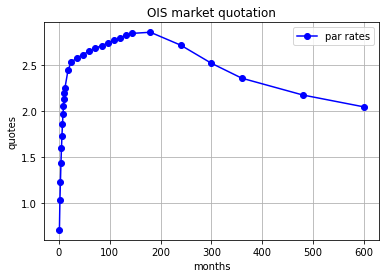

In [3]:
from matplotlib import pyplot as plt

plt.plot(ois_quotes['months'], ois_quotes['quotes'], label="par rates", color='b', marker='o')
plt.xlabel("months")
plt.ylabel("quotes")
plt.title("OIS market quotation")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# Now define the objective function: the sum of the squared NPVs of the OIS
import numpy as np

def of(dfs, pillars, swaps):
  dfs = np.insert(dfs, 0, 1)
  dc = DiscountCurve(pillars, dfs)
  val = 0
  for s in swaps:
    val += s.npv(dc)**2
  return val

# Now create the OIS from markets quotes (we need the class OvernightIndexSwap)
from myfm import OISwap

def make_swaps(data):
  pricing_date = date.today()
  pillar_dates = [pricing_date]
  swaps = []
  for i in range(len(data)):
    swap = OISwap(1e5, pricing_date, 
                              data.loc[i, 'months'],
                              data.loc[i, 'quotes']*0.01)
    swaps.append(swap)
    pillar_dates.append(swap.payment_dates[-1])
  return swaps, pillar_dates

swaps, pillar_dates = make_swaps(ois_quotes)

In [5]:
# Set boundaries and guess values

dfs0 = [1.0 for _ in range(len(swaps))]
bounds = [(0.01, 10) for _ in range(len(swaps))]

# Now minimize
from scipy.optimize import minimize

res = minimize(of, dfs0, bounds=bounds, args=(pillar_dates, swaps))
print (res)

# Finally, create the discount curve with our factors
from math import log
from dateutil.relativedelta import relativedelta

dfs = np.insert(res.x, 0, 1)

# Get the Discount Curve
disc_curve = DiscountCurve(pillar_dates,dfs)

      fun: 6.027142225043837e-06
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.11204684,  0.17638286,  0.20195546,  0.18536434,  0.13802388,
        0.08098006,  0.03571012,  0.01559454,  0.02198264,  0.04771021,
        0.0817759 , -0.1141743 , -0.09250349,  0.19047557,  0.08933371,
        0.02913078, -0.01764702, -0.02143768, -0.02722639, -0.0233751 ,
       -0.01872299, -0.00946514, -0.02935001, -0.34037027,  0.07520392,
       -0.35560906, -0.25365554,  0.01768214, -0.18359031,  0.0861051 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 465
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([0.99945138, 0.99831201, 0.99696347, 0.99525677, 0.99340215,
       0.99136706, 0.9892002 , 0.98696958, 0.98469213, 0.98239148,
       0.98001276, 0.97763574, 0.9638143 , 0.95044587, 0.92527826,
       0.90036952, 0.8752759 , 0.85061109, 0.8265085 , 0.80234949,
       0.77842018, 0.75456742, 0.73127098, 0.70888994

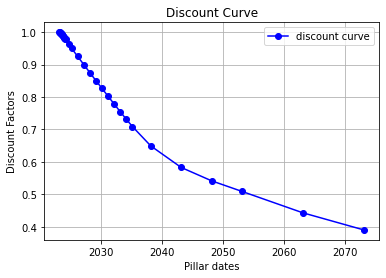

In [6]:
from matplotlib import pyplot as plt

plt.plot(pillar_dates, dfs, label="discount curve", color='b', marker='o')
plt.xlabel("Pillar dates")
plt.ylabel("Discount Factors")
plt.title("Discount Curve")
plt.grid(True)
plt.legend()
plt.show()

**Forward Rate Curve**

In [7]:
# Import the EURIBOR data sheets (1M, 3M, 6M) and the ForwardRateCurve class
from myfm import ForwardRateCurve

euribor_data_1m = pd.read_excel("euribor_curve.xlsx", sheet_name="EURIBOR1M")
euribor_data_3m = pd.read_excel("euribor_curve.xlsx", sheet_name="EURIBOR3M")
euribor_data_6m = pd.read_excel("euribor_curve.xlsx", sheet_name="EURIBOR6M")

In [8]:
# Generate the dates for the tenors we have in the excel file

m1_months = [ int(x) for x in euribor_data_1m["months"] ] 
m3_months = [ int(x) for x in euribor_data_3m["months"] ] 
m6_months = [ int(x) for x in euribor_data_6m["months"] ]

# We set "our" generate_dates for the dates of our Forward Curve
def my_generate_dates(start_date, my_months):
    dates = []
    for d in my_months:
      dates.append(start_date + relativedelta(months=d))
    return dates

m1_dates = my_generate_dates(pricing_date,m1_months)
m3_dates = my_generate_dates(pricing_date,m3_months)
m6_dates = my_generate_dates(pricing_date,m6_months)

# Generate the Forward Curve

frc_1m = ForwardRateCurve(m1_dates,euribor_data_1m["rates"]*0.01)
frc_3m = ForwardRateCurve(m3_dates,euribor_data_3m["rates"]*0.01)
frc_6m = ForwardRateCurve(m6_dates,euribor_data_6m["rates"]*0.01)

[]

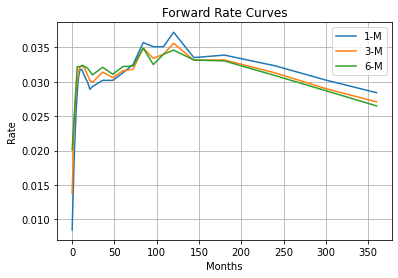

In [9]:
plt.plot(m1_months, frc_1m.rates,label="1-M")
plt.plot(m3_months, frc_3m.rates,label="3-M")
plt.plot(m6_months, frc_6m.rates,label="6-M")
plt.legend()
plt.xlabel("Months")
plt.ylabel("Rate")
plt.title("Forward Rate Curves")
plt.grid(True)
plt.plot()

**Basis Swaps**

To implement our class for the Basis Swaps, we use as references the following formulas, where

PV = present value of the Basis Swap

P(t0,ti) = discount factor for the period (ti - t0)

li = ith EURIBOR rate (in our code, it corresponds to F, using the notation of the classes' code)

N = swap notional

n,m = number of coupons for each tenor 

s = par spread

tau = year fraction 

t0 = time to evaluation date in years

ti = time to the i-th coupon payment date in years


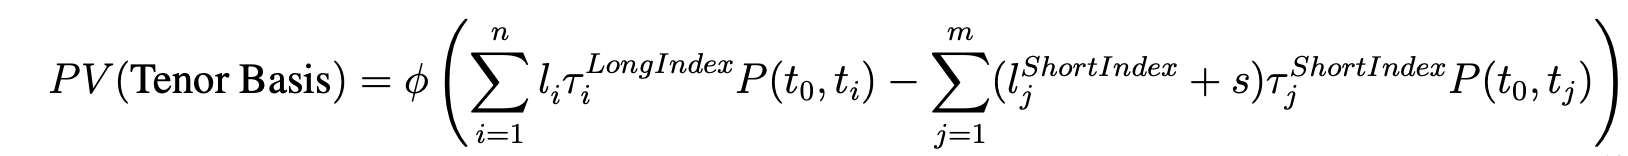

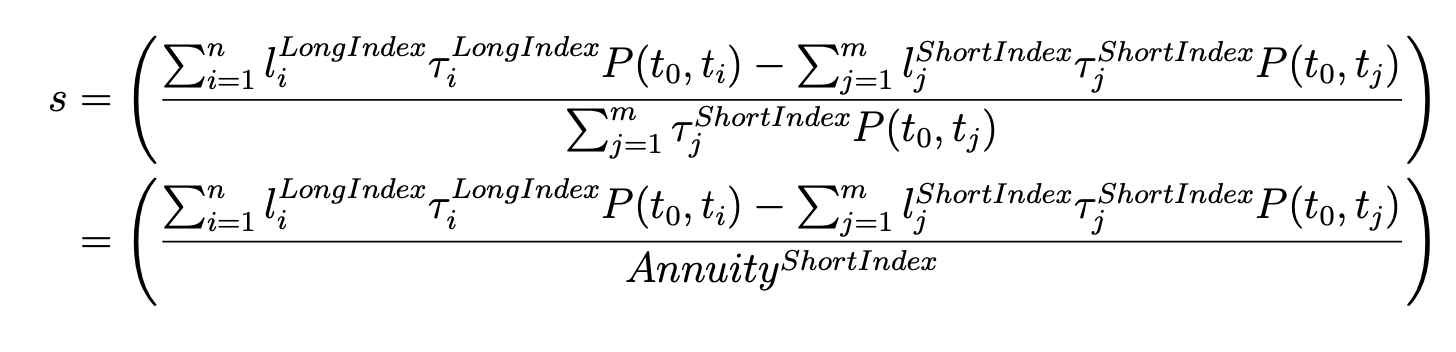

In [10]:
# Now import the generate_dates function to implement the class for the Basis Swaps 
from myfm import generate_dates

class BasisSwap:

    def __init__(self, pricing_date, notional, tenor1, tenor2, maturity):
        self.notional = notional
        self.tenor1_dates = generate_dates(pricing_date, maturity, tenor1)
        self.tenor2_dates = generate_dates(pricing_date, maturity, tenor2)
    
    def npv_tenor1(self, discount_curve, tenor1_lib_curve, spread):
        npv_t1 = 0
        for j in range(1, len(self.tenor1_dates)):
            F1 = tenor1_lib_curve.forward_rate(self.tenor1_dates[j-1],self.tenor1_dates[j])
            tau1 = (self.tenor1_dates[j] - self.tenor1_dates[j-1]).days / 360
            P1 = discount_curve.df(self.tenor1_dates[j])
            npv_t1 += (F1+spread) * tau1 * P1
        return npv_t1 * self.notional     
   
    def npv_tenor2(self, discount_curve, tenor2_lib_curve):
        npv_t2 = 0
        for i in range(1, len(self.tenor2_dates)):
            F2 = tenor2_lib_curve.forward_rate(self.tenor2_dates[i-1],self.tenor2_dates[i])
            tau2 = (self.tenor2_dates[i] - self.tenor2_dates[i-1]).days / 360
            P2 = discount_curve.df(self.tenor2_dates[i])
            npv_t2 += F2 * tau2 * P2
        return npv_t2 * self.notional
    
    def npv(self, discount_curve, tenor1_lib_curve, tenor2_lib_curve, spread):
        npv_t2 = self.npv_tenor2(discount_curve, tenor2_lib_curve)
        npv_t1 = self.npv_tenor1(discount_curve, tenor1_lib_curve, spread)
        return npv_t2 - npv_t1


    def basis_spread(self, discount_curve, tenor1_lib_curve, tenor2_lib_curve):
        val2 = 0
        for i in range(1, len(self.tenor2_dates)):
            F2 = tenor2_lib_curve.forward_rate(self.tenor2_dates[i-1],self.tenor2_dates[i])
            tau2 = (self.tenor2_dates[i] - self.tenor2_dates[i-1]).days / 360
            P2 = discount_curve.df(self.tenor2_dates[i])
            val2 += F2 * tau2 * P2
            
        val1 = 0
        annuity = 0
        for j in range(1, len(self.tenor1_dates)):
            F1 = tenor1_lib_curve.forward_rate(self.tenor1_dates[j-1],self.tenor1_dates[j])
            tau1 = (self.tenor1_dates[j] - self.tenor1_dates[j-1]).days / 360
            P1 = discount_curve.df(self.tenor1_dates[j])
            val1 += F1 * tau1 * P1
            annuity += tau1 * P1
            
        num = val2 - val1
        return num / annuity

In [11]:
# To compute the spreads of our pool of swaps, first import the data from excel file
bas_swaps = pd.read_csv("basis_swaps_proj1.csv")

# Set the class with our data and, finally, compute the par spread
print("Results: ")
my_spread=[]

for i in range(len(bas_swaps)):
    bs_sw = BasisSwap(pricing_date,
                     bas_swaps.loc[i, 'nominal'],
                     bas_swaps.loc[i, 'first_tenor'], 
                     bas_swaps.loc[i, 'second_tenor'],
                     bas_swaps.loc[i, 'maturity'])

    if bas_swaps.loc[i, 'first_tenor'] == 1 and bas_swaps.loc[i, "second_tenor"] == 3:
          print("{} {:.5f} ".format("Basis Swap "+str(i+1) + " par spread:",bs_sw.basis_spread(disc_curve, frc_1m, frc_3m)))
          my_spread.append(bs_sw.basis_spread(disc_curve, frc_1m, frc_3m))
    if bas_swaps.loc[i, 'first_tenor'] == 3 and bas_swaps.loc[i, "second_tenor"] == 6:
          print("{} {:.5f}".format("Basis Swap "+str(i+1) + " par spread", bs_sw.basis_spread(disc_curve, frc_3m, frc_6m)))
          my_spread.append(bs_sw.basis_spread(disc_curve, frc_3m, frc_6m))
    if bas_swaps.loc[i, 'first_tenor'] == 1 and bas_swaps.loc[i, "second_tenor"] == 6:
          print("{} {:.5f}".format("Basis Swap "+str(i+1) + " par spread", bs_sw.basis_spread(disc_curve, frc_1m, frc_6m)))
          my_spread.append(bs_sw.basis_spread(disc_curve, frc_1m, frc_6m)) 


Results: 
Basis Swap 1 par spread: 0.00064 
Basis Swap 2 par spread 0.00001
Basis Swap 3 par spread 0.00066
Basis Swap 4 par spread: 0.00055 
Basis Swap 5 par spread 0.00099
Basis Swap 6 par spread 0.00154
Basis Swap 7 par spread: 0.00026 
Basis Swap 8 par spread 0.00050
Basis Swap 9 par spread 0.00075
Basis Swap 10 par spread: -0.00120 
Basis Swap 11 par spread -0.00047
Basis Swap 12 par spread -0.00167
Basis Swap 13 par spread: -0.00154 
Basis Swap 14 par spread -0.00098
Basis Swap 15 par spread -0.00252


In [12]:
# To verify if our spreads are correctly computed, let's verify if the difference between the tenor 1 leg and tenor 2 leg , taking into account the par spread, is equal to zero

for i in range(len(bas_swaps)):
    bs_sw = BasisSwap(pricing_date,
                     bas_swaps.loc[i, 'nominal'],
                     bas_swaps.loc[i, 'first_tenor'], 
                     bas_swaps.loc[i, 'second_tenor'],
                     bas_swaps.loc[i, 'maturity'])
    if bas_swaps.loc[i, 'first_tenor'] == 1 and bas_swaps.loc[i, "second_tenor"] == 3:
          print("{} : {:0.5f}".format("Basis Swap_"+str(i+1)+" legs diff with par spread",bs_sw.npv_tenor2(disc_curve, frc_3m)- bs_sw.npv_tenor1(disc_curve,frc_1m,my_spread[i])))       
    if bas_swaps.loc[i, 'first_tenor'] == 3 and bas_swaps.loc[i, "second_tenor"] == 6:
          print("{} : {:0.5f}".format("Basis Swap_"+str(i+1)+" legs diff with par spread", bs_sw.npv_tenor2(disc_curve, frc_6m)- bs_sw.npv_tenor1(disc_curve,frc_3m,my_spread[i])))
    if bas_swaps.loc[i, 'first_tenor'] == 1 and bas_swaps.loc[i, "second_tenor"] == 6:
           print("{} : {:0.5f}".format("Basis Swap_"+str(i+1)+" legs diff with par spread", bs_sw.npv_tenor2(disc_curve, frc_6m)- bs_sw.npv_tenor1(disc_curve,frc_1m,my_spread[i])))     

Basis Swap_1 legs diff with par spread : -0.00000
Basis Swap_2 legs diff with par spread : 0.00000
Basis Swap_3 legs diff with par spread : 0.00000
Basis Swap_4 legs diff with par spread : 0.00000
Basis Swap_5 legs diff with par spread : -0.00000
Basis Swap_6 legs diff with par spread : 0.00000
Basis Swap_7 legs diff with par spread : -0.00000
Basis Swap_8 legs diff with par spread : 0.00000
Basis Swap_9 legs diff with par spread : 0.00000
Basis Swap_10 legs diff with par spread : 0.00000
Basis Swap_11 legs diff with par spread : 0.00000
Basis Swap_12 legs diff with par spread : 0.00000
Basis Swap_13 legs diff with par spread : 0.00000
Basis Swap_14 legs diff with par spread : 0.00000
Basis Swap_15 legs diff with par spread : -0.00000


Text(0, 0.5, 'EURIBOR1M rates')

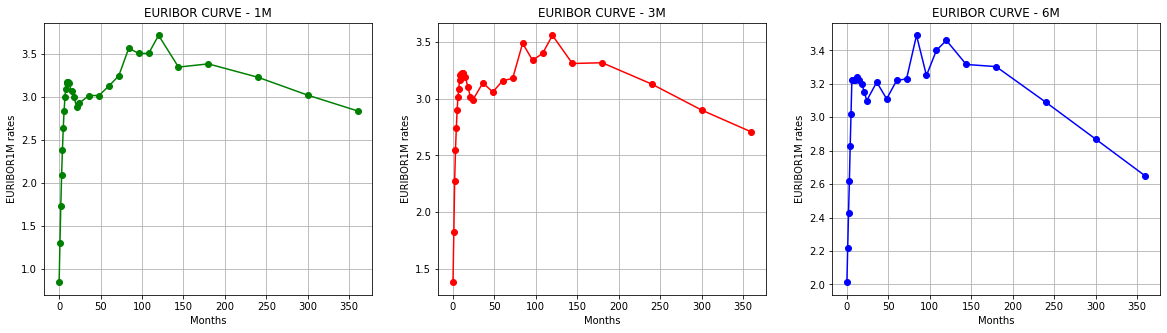

In [13]:
# Focusing on the value of our par spread whit respect the tenor difference, it is not possible to identify a linear pattern. This is due to the fact that
# in each EURIBOR curve, the rates have an unregular path. It first increases, then there is a decrease. 

plt.figure(figsize=(20,5))

# Plot for the Euribor Curve - 1M
plt.subplot(1,3,1)
plt.plot(euribor_data_1m["months"],euribor_data_1m["rates"],marker ="o",color="g")
plt.grid(True)
plt.title("EURIBOR CURVE - 1M")
plt.xlabel("Months")
plt.ylabel("EURIBOR1M rates")

# Plot for the Euribor Curve - 3M
plt.subplot(1,3,2)
plt.plot(euribor_data_3m["months"],euribor_data_3m["rates"],marker ="o",color="r")
plt.grid(True)
plt.title("EURIBOR CURVE - 3M")
plt.xlabel("Months")
plt.ylabel("EURIBOR1M rates")

# Plot for the Euribor Curve - 6 M
plt.subplot(1,3,3)
plt.plot(euribor_data_6m["months"],euribor_data_6m["rates"],marker ="o",color="b")
plt.grid(True)
plt.title("EURIBOR CURVE - 6M")
plt.xlabel("Months")
plt.ylabel("EURIBOR1M rates")

IMPLEMENTATION BISECTION METHOD

In [14]:
# We define 3 function, one for each couples of tenor (1-3, 3-6,1-6)
def ten_13(s):
    return bs_sw.npv(disc_curve, frc_1m, frc_3m,s)

def ten_36(s):
    return bs_sw.npv(disc_curve, frc_3m, frc_6m,s)

def ten_16(s):
    return bs_sw.npv(disc_curve, frc_1m, frc_6m,s)

In [15]:
from scipy.optimize import bisect

bas_swaps = pd.read_csv("basis_swaps_proj1.csv")

par_spread=[]

for i in range(len(bas_swaps)):
    bs_sw = BasisSwap(pricing_date,
                     bas_swaps.loc[i, 'nominal'],
                     bas_swaps.loc[i, 'first_tenor'], 
                     bas_swaps.loc[i, 'second_tenor'],
                     bas_swaps.loc[i, 'maturity'])
    if bas_swaps.loc[i, 'first_tenor'] == 1 and bas_swaps.loc[i, "second_tenor"] == 3:
         spread= bisect(ten_13,-1,1)
         par_spread.append(spread)
    if bas_swaps.loc[i, 'first_tenor'] == 3 and bas_swaps.loc[i, "second_tenor"] == 6:
         spread= bisect(ten_36,-1,1)
         par_spread.append(spread)
    if bas_swaps.loc[i, 'first_tenor'] == 1 and bas_swaps.loc[i, "second_tenor"] == 6:
         spread= bisect(ten_16,-1,1)
         par_spread.append(spread)

In [16]:
for i in range(len(par_spread)):
    print("{}  par spread : {:.5f}".format(str(i+1), par_spread[i]))

1  par spread : 0.00064
2  par spread : 0.00001
3  par spread : 0.00066
4  par spread : 0.00055
5  par spread : 0.00099
6  par spread : 0.00154
7  par spread : 0.00026
8  par spread : 0.00050
9  par spread : 0.00075
10  par spread : -0.00120
11  par spread : -0.00047
12  par spread : -0.00167
13  par spread : -0.00154
14  par spread : -0.00098
15  par spread : -0.00252


Verification between the value of the par spreads with the 2 different methods

In [17]:
print("  CLASS METHOD      " " BISECTION METHOD ")
for i in range(len(par_spread)):
    print("   {:.5f}                {:.5f}".format(my_spread[i], par_spread[i]))

  CLASS METHOD       BISECTION METHOD 
   0.00064                0.00064
   0.00001                0.00001
   0.00066                0.00066
   0.00055                0.00055
   0.00099                0.00099
   0.00154                0.00154
   0.00026                0.00026
   0.00050                0.00050
   0.00075                0.00075
   -0.00120                -0.00120
   -0.00047                -0.00047
   -0.00167                -0.00167
   -0.00154                -0.00154
   -0.00098                -0.00098
   -0.00252                -0.00252
